In [48]:
import pandas as pd
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import gym
from gym.envs.registration import register

# 아래의 방식을 통해 게임을 등록함. 특히 is_slippery는 매우 중요함. 
"""
- 새로운 게임 형식을 만들어줌.
"""
register(
    id='FrozenLakeNotSlippery-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

In [100]:
env = gym.make("FrozenLakeNotSlippery-v1")
observation = env.reset()

"""
0: left, 1: down, 2: right, 3: up 
"""
for i in range(0, 1):
    action = env.action_space.sample()# randomly select action 
    """
    - new_state: 액션을 취해서 새롭게 옮겨진 위치 
    - reward: 보상을 얻었는지 여부
    - done: 게임이 끝났는지 여부(hole에 빠지거나, )
    """
    new_state, reward, done, _ = env.step(action)
    env.render()

#####
##
env = gym.make("FrozenLakeNotSlippery-v1")
observation = env.reset()
complete_actions = [2, 2, 1, 1, 1, 2]
for action in actions:
    new_state, reward, done, _ = env.step(action)
    env.render()
    if done is True:
        print("done, reward: {}".format(reward))

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
done, reward: 1.0


complete


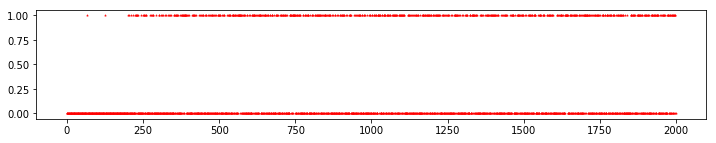

[[ 0.94148015  0.95099005  0.95099005  0.94148015]
 [ 0.94148015  0.          0.96059601  0.95099005]
 [ 0.95099005  0.970299    0.95099005  0.96059601]
 [ 0.96059601  0.          0.95099005  0.95099005]
 [ 0.95099005  0.96059601  0.          0.94148015]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.9801      0.          0.96059601]
 [ 0.          0.          0.          0.        ]
 [ 0.96059601  0.          0.970299    0.95099005]
 [ 0.96059601  0.9801      0.9801      0.        ]
 [ 0.970299    0.99        0.          0.970299  ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.9801      0.99        0.970299  ]
 [ 0.9801      0.99        1.          0.9801    ]
 [ 0.          0.          0.          0.        ]]


In [259]:
"""
- 사실 이런 형태의 미로에서는 reward를 끝나봐야 얻습니다. 끝날때까지 reward가 어디있는지 모른다는 이야기죠. 
- 비슷하게, 장기 바둑도 마찬가지입니다. 이전의 어떤 수가 reward를 결정했는지는 알기가 어려우니까요.
- 아무튼, 그러므로, dummy Q-learning algorithm에서는 t+1 state의 reward의 max값을 t state의 reward의 max 값으로 정합니다. 
    - 미래의 리워드를 현재의 리워드로 가져온다는 말이 이상하지만, 이걸 정리하면, "이번 게임에서 t+1 스텝
"""
def rargmax_new(vector):
    """
    max가 여러 개 있을 경우, 그중에서 random 하게 고름
    """
    m = vector.max() 
    indices = [i for i, v in enumerate(vector==m) if v==True]
    return np.random.choice(indices)
# how to is slippely false
env = gym.make("FrozenLakeNotSlippery-v1")
observation = env.reset()

Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 2000 # 일종의 epoch, 혹은 라이프.
decay_rate = 0.99 
# reward는 전달 과정에서 누가 계속 까먹기 때문에, decay rate가 발생함. 
# 또한, 이렇게 모델링 해야, 짧은 path를 거쳐 지나온 놈의 경우에 step에서 높은 Q(partial reward)를 가짐 

rlist = []
for i in range(0, num_episodes):
    state = env.reset()
    e = 1. / ((i//100)+1)
    """
    goal에 이르는 답이 여러가지일 수 있는데, 어느 정도의 랜덤성을 통해서 탐험을 하지 않을 경우, 초기의 답만을 가지게 됨. 
    사실 미로의 경우는 탐험을 통해 더 짧은 길을 찾을 수도 있음.
    """
    #env.render()
    rAll = 0 # 한 episode 별로 얻을 수 있는 reward의 총합
    done = False # hole에 빠지거나, Goal에 도달하면 True
    while not done:
        # 탐험을 통해 더 좋은 길을 확보
        if np.random.randn(1) < e: 
            # np.random.randn 은 norm(0, 1)
            # 즉, 에피소드가 반복되어 e가 감소되어도, 대략 0.5 정도의 확률로 탐험을 하는 것이 가능해야 함. 
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        new_state, reward, done, _ = env.step(action)
        Q[state, action] = reward + decay_rate*np.max(Q[new_state, :])
        rAll+=reward
        state = new_state # state update
    rlist.append(rAll)
print('complete')

"""
- 처음에는 잘 못 맞추다가, 한 두번 맞추기 시작하면서 부터는 슥슥 매우 잘 맞춤
- 그냥 random으로 시행할 경우에는, 1.3%의 확률로 reward 획득
"""
plt.figure(figsize=(12, 2))
plt.scatter(range(0, len(rlist)), rlist, marker='^', s=1, color='red')
plt.show()

"""
0: left, 1: down, 2: right, 3: up 
"""
print(Q)

#pd.DataFrame(Q, index = [(i//4, i%4) for i in range(0, Q.shape[0])], columns=['left', 'down', 'right', 'up'])



In [244]:
"""
turtle 가지고 뭔가 장난을 좀 칠 수 있을 것 같은데 
"""
from turtle import *
color('red', 'yellow')
begin_fill()
while True:
    forward(200)
    left(170)
    if abs(pos()) < 1:
        break
end_fill()
done()